<a href="https://colab.research.google.com/github/nayaras/IA/blob/master/regressao_logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Logística

---
Instituto Federal do Norte de Minas Gerais Campus Montes Claros <br/>

Disciplina: Inteligência Artificial <br/>
Curso: Ciência da Computação  <br/>
Professora: Luciana Balieiro Cosme  <br/>
Desenvolvido por: Eike Stálei, Marianna Leandra M. Silva, Nayara Thaiza P. Soares 


---

A regressão logística é usada em problemas de classificação binária com os quais o objetivo é separar previsões em duas classes distintas com base em um limite de probabilidade.


In [1]:
#importações
import numpy as np  
import pandas as pd  
import random
import math
import operator
from numpy import genfromtxt
from random import randrange
#dados
from sklearn import datasets
from sklearn.datasets import load_boston
#plot
import matplotlib.pyplot as plt

#regressão logistica
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV



boston = load_boston()
#itens da base
boston.keys()

print(boston.DESCR)





.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [2]:
#converte a base de dados
import pandas

dataset = pandas.DataFrame(boston.data) 
dataset = dataset.astype('float64') # converte para float
dataset.columns = boston.feature_names

dataset.head(10)



,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


Adaptando a base boston para ser de classificação
Como a base boston não é uma base própria para classificação como a boston, escolhi a coluna RM, que é a média número de cômodos das casas por bairro para discretizar. <br />
Para isso, primeiro realizei a verificação do maior número de cômodos, menor e média, entrentanto, ao plotar o gráfico de todos os valores, foi possível perceber que o máximo e o mínimo são pontos de outlier, logo, fiz uma aproximação perto da média.

Max:  8.78
Min:  3.561
Média:  6.284634387351787


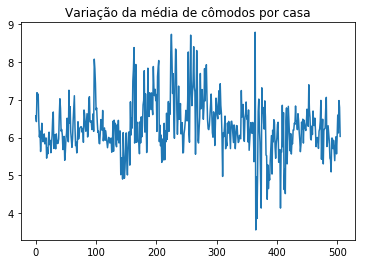

In [3]:
#dataset['RM'] = pandas.to_numeric(dataset['RM'])
#RM é num de comodos medio por casa
print("Max: ", max(dataset['RM']))
print("Min: ", min(dataset['RM']))
soma = sum(dataset['RM'])
print("Média: ", soma/506)

for var in ['RM']:
    x = dataset[var].values  
    plt.plot(x)
    plt.title('Variação da média de cômodos por casa')

plt.show()

**Assim, ficou definido que as casas com média abaixo de 6 cômodos são consideradas casas pequenas (0), as casas com média acima de 6.5 são consideradas casas grandes e entre os dois valores são casas de tamanho médio** <br/>
Esta aproximação buscou equilibrar o numero de dados em cada um dos três grupos.

In [4]:
maior = dataset[dataset['RM'] > 6.5]['RM'].index.tolist()
print(len(maior))
menor = dataset[dataset['RM'] < 6]['RM'].index.tolist()
print(len(menor))

med = dataset['RM'][(dataset['RM'].values > 6) & (dataset['RM'].values < 6.5)].index.tolist()
print(len(med))


dataset['RM'][menor] = 2  #'CASA_PEQUENA'
dataset['RM'][med] = 3 #'CASA_MEDIA'
dataset['RM'][maior] = 4 #'CASA_GRANDE'

152
173
181


In [5]:
observ = len(boston.data)
carac = len(dataset.columns)
print("Numero de observações (linhas): " + str(observ))
print("Numero de caracteristicas: " + str(carac))


comodos_map = {2: 'CASA_PEQUENA', 3: 'CASA_MEDIA', 4: 'CASA_GRANDE'}

#mostrando a coluna RM modificada com o nosso filtro.
dataset['TIPO'] = dataset['RM'].map(comodos_map)
dataset.head(10)



Numero de observações (linhas): 506
Numero de caracteristicas: 13


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TIPO
0,0.00632,18.0,2.31,0.0,0.538,4.0,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,CASA_GRANDE
1,0.02731,0.0,7.07,0.0,0.469,3.0,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,CASA_MEDIA
2,0.02729,0.0,7.07,0.0,0.469,4.0,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,CASA_GRANDE
3,0.03237,0.0,2.18,0.0,0.458,4.0,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,CASA_GRANDE
4,0.06905,0.0,2.18,0.0,0.458,4.0,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,CASA_GRANDE
5,0.02985,0.0,2.18,0.0,0.458,3.0,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,CASA_MEDIA
6,0.08829,12.5,7.87,0.0,0.524,3.0,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,CASA_MEDIA
7,0.14455,12.5,7.87,0.0,0.524,3.0,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,CASA_MEDIA
8,0.21124,12.5,7.87,0.0,0.524,2.0,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,CASA_PEQUENA
9,0.17004,12.5,7.87,0.0,0.524,3.0,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,CASA_MEDIA


**Visto que menos caracteristicas fornece um melhor resultado, defini que somente trataria dos dados: <br />
RM: Como já dito é a média de cômodos em casas por bairro  <br />
AGE: Idades das casas  <br />
DIS: Distância do centro da cidade  <br />
LSTAT: Status socioeconomico da população em porcentagem  <br />**
Assim, todas as outras colunas foram removidas do nosso conjunto de dados

In [6]:
dataset = dataset.drop('CRIM',axis=1)
dataset = dataset.drop('ZN',axis=1)
dataset = dataset.drop('INDUS',axis=1)
dataset = dataset.drop('CHAS',axis=1)
dataset = dataset.drop('NOX',axis=1)
dataset = dataset.drop('RAD',axis=1)
dataset = dataset.drop('TAX',axis=1)
dataset = dataset.drop('PTRATIO',axis=1)
dataset = dataset.drop('B',axis=1)


print(dataset.head(10))
X_boston = dataset
y_boston = dataset['RM'].values
y2 = boston.target

    RM    AGE     DIS  LSTAT          TIPO
0  4.0   65.2  4.0900   4.98   CASA_GRANDE
1  3.0   78.9  4.9671   9.14    CASA_MEDIA
2  4.0   61.1  4.9671   4.03   CASA_GRANDE
3  4.0   45.8  6.0622   2.94   CASA_GRANDE
4  4.0   54.2  6.0622   5.33   CASA_GRANDE
5  3.0   58.7  6.0622   5.21    CASA_MEDIA
6  3.0   66.6  5.5605  12.43    CASA_MEDIA
7  3.0   96.1  5.9505  19.15    CASA_MEDIA
8  2.0  100.0  6.0821  29.93  CASA_PEQUENA
9  3.0   85.9  6.5921  17.10    CASA_MEDIA


In [7]:
#misturando os dados
perm = np.random.permutation(len(boston.data))
dataset = dataset.loc[perm]
dataset.head()

,RM,AGE,DIS,LSTAT,TIPO
358,3.0,83.4,2.7227,11.48,CASA_MEDIA
436,3.0,93.3,2.0026,18.05,CASA_MEDIA
59,2.0,47.2,6.9320,9.22,CASA_PEQUENA
79,2.0,36.6,4.5026,9.10,CASA_PEQUENA
70,3.0,6.6,5.2873,6.72,CASA_MEDIA


**Contabilizando a quantidade de cada tipo de cômodos**

In [8]:
casa_grande_mask = dataset['TIPO'] == 'CASA_GRANDE'
dataset[casa_grande_mask].describe()

,RM,AGE,DIS,LSTAT
count,152.0,152.000000,152.000000,152.000000
mean,4.0,59.744079,4.325154,7.449737
std,0.0,28.473526,2.219851,4.998417
min,4.0,2.900000,1.202400,1.730000
25%,4.0,33.425000,2.523700,4.432500
50%,4.0,61.800000,3.651900,5.900000
75%,4.0,86.600000,5.903850,8.227500
max,4.0,100.000000,12.126500,25.790000


In [9]:
casa_media_mask = dataset['TIPO'] == 'CASA_MEDIA'
dataset[casa_media_mask].describe()

,RM,AGE,DIS,LSTAT
count,181.0,181.000000,181.000000,181.000000
mean,3.0,68.672928,3.852726,12.470663
std,0.0,28.430717,1.979218,5.240595
min,3.0,6.000000,1.169100,3.590000
25%,3.0,45.800000,2.206000,8.200000
50%,3.0,79.700000,3.262800,11.970000
75%,3.0,93.600000,5.400700,15.550000
max,3.0,100.000000,9.220300,29.050000


In [10]:
casa_pequena_mask = dataset['TIPO'] == 'CASA_PEQUENA'
dataset[casa_pequena_mask].describe()

,RM,AGE,DIS,LSTAT
count,173.0,173.000000,173.000000,173.000000
mean,2.0,76.231214,3.268929,17.415607
std,0.0,25.315182,2.015596,7.229999
min,2.0,9.800000,1.129600,3.260000
25%,2.0,59.600000,1.755400,12.120000
50%,2.0,88.400000,2.469900,15.840000
75%,2.0,96.700000,4.098300,21.450000
max,2.0,100.000000,10.710300,37.970000


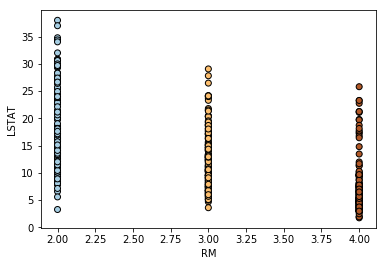

In [11]:


plt.scatter(X_boston.iloc[:, 0], X_boston.iloc[:, 3], c=y_boston, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('RM')
plt.ylabel('LSTAT')


#plt.xticks(())
#plt.yticks(())

plt.show()






**Refinando y binário pela coluna RM, classificaremos nossa base em ser casa grande ou não (todas as casas grandes serão 1 e o resto 0).**


In [12]:
X_boston = np.c_[X_boston.iloc[:, 0], X_boston.iloc[:, 3]]
y = []

for i in range(len(X_boston)):
  if X_boston[i][0] > 3:
    y.append(1)
  else:
    y.append(0)
    
    

print('Tamanho de y: ', len(y))

Tamanho de y:  506


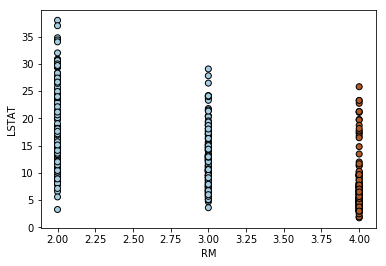

In [13]:
#plotando os grupos (marrom é casa grande, azul o resto)
y = np.array(y)
plt.scatter(X_boston[:,0], X_boston[:,1], c = y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('RM')
plt.ylabel('LSTAT')
plt.show()


O eixo y é composto pela porcentagem de classe social, assim, pelos gráficos acima, é possível perceber que a porcentagem de proprietários na vizinhança considerados de "classe baixa" é menor quando em comparação com casas consideradas grandes. <br/>

Agora vamos separar o conjunto de treinamento/teste para usar o modelo de Regressão Logística.

In [0]:
x_train, x_test = X_boston[perm][102:], X_boston[perm][:102]
y_train, y_test = y[perm][102:], y[perm][:102]

In [15]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((404, 2), (404,), (102, 2), (102,))

In [0]:
log_reg = LogisticRegression(solver='lbfgs')

In [17]:
#log_reg.fit(X_boston, y)

log_reg.fit(x_train,y_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = log_reg.predict(x_test)

In [19]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[80,  0],
       [ 0, 22]])

In [20]:
W, b = log_reg.coef_, log_reg.intercept_
W, b

(array([[ 5.91189511, -0.09731496]]), array([-19.76230246]))

Seguindo a forma linear Y = Mx + b, podemos ver agora que a equação linear para nosso limite de decisão é RM * (5,...) + LSTAT * (-0,...) + (-19,...). 

**Abaixo**, chamamos os primeiros 10 resultados de probab, que retornam a probabilidade prevista de cada ponto de dados. 

In [0]:
probab = []
for i in range(len(x_train)):
  probab.append( log_reg.predict_proba(x_train)[i])
  

In [22]:
#o primeiro valor retorna a probabilidade de não ser casa grande e o segundo a probabilidade de ser
probab[0:10]

[array([0.03997246, 0.96002754]),
 array([0.93498889, 0.06501111]),
 array([9.99940188e-01, 5.98121555e-05]),
 array([0.97719821, 0.02280179]),
 array([0.03715919, 0.96284081]),
 array([0.97355891, 0.02644109]),
 array([0.02868454, 0.97131546]),
 array([9.99904951e-01, 9.50490332e-05]),
 array([0.94835018, 0.05164982]),
 array([0.93282667, 0.06717333])]

In [23]:
print(x_train[0][0])
print(x_train[1][0])

4.0
3.0


**Gráfico de dispersão da probabilidade**

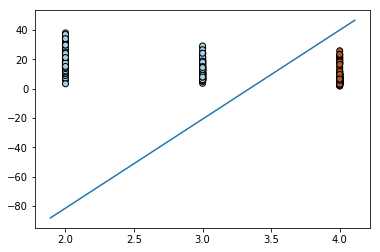

In [24]:
plt.scatter(X_boston[:,0], X_boston[:,1], c = y,  edgecolors='k', cmap=plt.cm.Paired)
ax = plt.gca()
ax.autoscale = False
xvals = np.array(ax.get_xlim())
yvals = -(xvals * W[0][0] + b) / W[0][1]
plt.plot(xvals, yvals)
plt.show()

Podemos ver que fomos capazes de separar facilmente as duas classes usando nosso limite de decisão de regressão logística. A linha representa o limite de 50% de chance, ou seja, quanto mais longe o ponto de dados, maior a probabilidade de o item ser uma determinada classe. Vamos agora prever o nosso conjunto de testes.

In [25]:
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0])

In [26]:
y_test

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0])

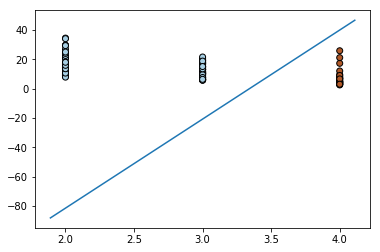

In [27]:
plt.scatter(x_test[:,0], x_test[:,1], c = y_test,  edgecolors='k', cmap=plt.cm.Paired)
ax = plt.gca()
ax.autoscale = False
xvals = np.array(ax.get_xlim())
yvals = -(xvals * W[0][0] + b) / W[0][1]
plt.plot(xvals, yvals)
plt.show()

Para o conjunto de teste, este modelo é capaz de prever com precisão quais casas são grandes e quais não são.

In [28]:
from sklearn.metrics import classification_report 
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        22

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102



**Referências:** <br />
https://blog.goodaudience.com/classifying-flowers-using-logistic-regression-in-sci-kit-learn-38262416e4c6 <br/>

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8